# Class 10: Clustering & Community Detection 1 — Traditional

Goal of today's class:
1. Define what network communities are
2. Explore and define the *modularity* measure 
3. Code some early algorithms for community detection

*Acknowledgement: Some of the material in this lesson is based on a previous course offered by Matteo Chinazzi and Qian Zhang.*
__________

1. Come in. Sit down. Open Teams.
2. Make sure your notebook from last class is saved.
3. Open up the Jupyter Lab server.
4. Open up the Jupyter Lab terminal.
5. Activate Conda: `module load anaconda3/2022.05`
6. Activate the shared virtual environment: `source activate /courses/PHYS7332.202510/shared/phys7332-env/`
7. Run `python3 git_fixer2.py`
8. Github:
    - git status (figure out what files have changed)
    - git add ... (add the file that you changed, aka the `_MODIFIED` one(s))
    - git commit -m "your changes"
    - git push origin main
________

In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')
rc('axes', axisbelow=True)

## Community Detection in Networks

Community detection is one of the most important tasks in network science and graph theory, focusing on identifying groups of nodes that are more densely connected to each other than to the rest of the network. These groups, often referred to as **communities**, **modules**, **clusters**, **blocks** are essential for understanding the structure and function of complex systems represented as graphs, such as social networks, biological systems, and information networks.

---

### What is a Community?

A **community** in a network can be intuitively understood as a subset of nodes where connections (edges) between members of the community are more frequent or stronger than connections to the rest of the network. In mathematical terms, a graph $ G = (V, E) $, where $ V $ represents the set of nodes and $ E $ represents the set of edges, can be partitioned into communities $ C_1, C_2, \dots, C_k $ such that:

$$
\sum_{i=1}^{k} \left( \text{Intra-community edges in } C_i \right) \gg \text{Inter-community edges between } C_i \text{ and other communities}.
$$

This means that each community $ C_i $ has a higher density of internal connections compared to its connections to other communities in the network.


A **community** is generally defined as a subset of nodes that are densely connected internally, but sparsely connected to nodes outside the community. In other words, members of a community have many intra-community edges but relatively few inter-community edges.

#### Mathematically:
For a given community $ C \subseteq V $, the internal density of edges is much higher than the external density:

$$
\frac{\text{Intra-community edges in } C}{|C|}
$$
should be maximized, while the number of **inter-community edges** should be minimized.

The goal of **community detection** is to partition the nodes of the network into communities $ C_1, C_2, \dots, C_k $ such that the intra-community connections are maximized and inter-community connections are minimized. Formally, the network is partitioned into $ k $ subsets:

$$
V = \bigcup_{i=1}^{k} C_i \quad \text{with} \quad C_i \cap C_j = \emptyset \quad \forall i \neq j.
$$

In practice, community detection helps in revealing the underlying structure of the network and offers insights into the network's functional modules, social groups, or thematic clusters.

---



#### More Formal Definitions of Communities

Communities can be defined in several ways, each based on different structural properties:

##### a. Clique:
A **clique** is the most restrictive form of a community, where every node is connected to every other node in the community. In a graph, a clique of size $ k $ is a subgraph $ K_k $ where every pair of nodes has an edge:

$$ \forall v_i, v_j \in C : (v_i, v_j) \in E. $$

However, real-world networks rarely exhibit perfect cliques.

##### b. Dense Subgraph:
A less restrictive notion than cliques, a dense subgraph satisfies a high ratio of existing edges to potential edges. The density $ d(C) $ of a community $ C $ is defined as:

$$ d(C) = \frac{|E_C|}{|C|(|C| - 1) / 2}, $$

where $ E_C $ represents the number of edges within community $ C $. A high density indicates a tightly-knit group.

##### c. Conductance:
The **conductance** of a community $ C $ measures the fraction of total edge volume that points outside the community:

$$ \Phi(C) = \frac{\sum_{i \in C, j \notin C} A_{ij}}{\min(\text{vol}(C), \text{vol}(V \setminus C))}, $$

where $ \text{vol}(C) $ is the sum of degrees of nodes in $ C $. Low conductance implies strong community structure.

---


### Applications of Community Detection

Community detection has wide-ranging applications across various disciplines:

- **Social Networks**: Communities often correspond to real-world groups such as families, friends, or professional associations.
- **Biological Networks**: In protein-protein interaction networks, communities may represent functional modules of proteins working together.
- **Information Networks**: In citation networks, communities may represent topics or research areas.
- **Infrastructure**: In power grids or transportation networks, communities can indicate regions or hubs that are densely interconnected.

By identifying communities, one can gain insights into the **organization**, **function**, and **dynamics** of complex systems.

---

### Types of Communities

Communities can be defined in different ways, depending on the nature of the network and the type of analysis required:

- **Disjoint Communities**: Each node belongs to exactly one community. Most algorithms, such as **Louvain** or **Girvan-Newman**, find disjoint partitions.
- **Overlapping Communities**: Nodes can belong to more than one community, which is useful for networks where entities have multiple affiliations (e.g., people belonging to different social groups).
- **Hierarchical Communities**: Communities can be nested, forming a hierarchy where smaller, denser communities are part of larger ones. This is common in many real-world networks like biological systems and organizational structures.

_________
Community detection is a critical tool for uncovering the hidden structure in complex networks, offering insights into how systems are organized. While many algorithms have been proposed, choosing the right one depends on the nature of the network, the expected community structure, and the scalability required for the task. Ongoing research continues to improve methods for detecting overlapping, hierarchical, and dynamic communities, making this an exciting area of study in network science.

Community detection continues to be a dynamic field of research with applications spanning biology, sociology, economics, and computer science. Despite the wealth of methods available, no single algorithm works best for all types of networks, and researchers must often tailor their approaches based on the specific structure and dynamics of the network at hand.

As networks become larger and more complex, the demand for scalable, accurate, and interpretable community detection methods will only grow. Future research will likely focus on multi-layer, overlapping, and dynamic community detection, along with developing new performance measures beyond modularity.

_________
## Modularity

One of the most widely used metrics for evaluating the quality of a community structure is **modularity**, proposed by Newman and Girvan (2004). Modularity purports to measure the difference between the actual number of intra-community edges and the expected number of such edges in a random graph with the same degree distribution. The modularity, $Q$, of a given partition $C$ of our adjacency matrix $A$ is:

$$Q (A,C) = \frac{1}{2M} \sum_{i,j} \left( A_{ij} - \frac{k_i k_j}{2M} \right) \delta (C_i,C_j) $$

Where:
- $ A_{ij} $ is the element of the adjacency matrix (1 if there is an edge between nodes $i$ and $j$, 0 otherwise).
- $ k_i $ and $ k_j $ are the degrees of nodes $i$ and $j$, respectively.
- $ M $ is the total number of edges in the network.
- $ \delta(C_i, C_j) $ is a Kronecker delta, equal to 1 if nodes $i$ and $j$ are in the same community, and 0 otherwise.

Modularity values range from $-1$ to $1$, with higher values indicating stronger community structure. According to some in the early literature of modularity, values of $ Q \approx 0.3 $ or higher can signify a significant division into communities.\*


\* **Note: Today, there are strong and damning critiques of modularity as a measure. We are introducing it here as a historical exercise and as a way to motivate next class's theme: *inferential approaches to community detection*.**

________

### Popular Community Detection Algorithms

Several algorithms have been developed for detecting communities in networks, each with different approaches and optimizations:

#### 1. **Girvan-Newman Algorithm**:
The **Girvan-Newman** algorithm is a hierarchical method based on **betweenness centrality** of edges. The idea is to iteratively remove edges with the highest betweenness centrality, causing the network to break into disconnected components.

- **Betweenness Centrality**: For an edge $ e $, the betweenness centrality is the number of shortest paths between all pairs of nodes that pass through $ e $.
  
The process continues until the network splits into predefined or data-driven numbers of communities.

**Time complexity**: $ O(n^3) $, making it impractical for large networks.

#### 2. **Louvain Method**:
The **Louvain method** is a popular greedy optimization technique for maximizing modularity. It works in two phases:
1. **Local Modularity Maximization**: Each node is initially assigned to its own community. Nodes are then reassigned to neighboring communities if doing so increases modularity.
2. **Community Aggregation**: Once no more reassignments can improve modularity, the network is compressed by treating each community as a "super-node."

This process is repeated until no further improvement in modularity is possible.

**Time complexity**: $ O(n \log n) $, making it scalable for large networks.

#### 3. **Infomap Algorithm**:
The **Infomap** algorithm approaches community detection from an information-theoretic perspective. It models random walks on the graph and optimizes the coding length needed to describe these walks.

- The idea is to partition the network such that a random walker spends more time within communities than between them, leading to a more concise encoding of its movement.
  
Infomap is known for detecting hierarchical and overlapping communities.

**Time complexity**: $ O(m \log n) $.

#### 4. **Spectral Clustering**:
**Spectral clustering** relies on the eigenvalues and eigenvectors of the **graph Laplacian** matrix. The **Laplacian matrix** $ L $ is defined as:

$$ L = D - A, $$

where $ D $ is the degree matrix and $ A $ is the adjacency matrix. Spectral clustering leverages the second-smallest eigenvalue (the **Fiedler value**) and the corresponding eigenvector to find the best partition of nodes into communities.

**Time complexity**: $ O(n^3) $, as eigenvalue decomposition can be computationally intensive.


_________
#### And many... many... many more...
![](images/karate_fig.png)
---

_____________

### Challenges in Community Detection

Although significant progress has been made in developing community detection algorithms, several challenges remain:

#### Resolution Limit:
Modularity-based methods, like Louvain, suffer from a **resolution limit**, meaning that they may fail to detect small but dense communities. This occurs because modularity optimization tends to merge small communities into larger ones when

 it improves the overall modularity score.

#### Overlapping Communities:
In many real-world networks, communities often overlap, i.e., nodes belong to multiple communities (e.g., in social networks, a person can belong to multiple social groups). Most traditional algorithms are designed to find disjoint communities, making it difficult to handle overlapping structures.

#### Dynamic and Evolving Communities:
Real-world networks are often dynamic, meaning nodes and edges can appear and disappear over time. Detecting communities in evolving networks requires more sophisticated methods that take temporal dynamics into account.

#### Computational Complexity:
For large-scale networks (millions of nodes and edges), community detection becomes computationally expensive. Scalability and performance optimizations are essential for practical applications in big data networks.

---

### Examples of Advanced Topics in Community Detection

#### Stochastic Block Models (SBM):
Stochastic block models are probabilistic models that generate networks with a predefined community structure. In an SBM, edges between nodes are created based on probabilities determined by the community assignments of the nodes. **This will be the topic of next class's discussion.**

#### Label Propagation:
Label Propagation is a simple and efficient algorithm where each node adopts the most frequent community label among its neighbors. This process is repeated until no node changes its label. The method is fast but may lead to unstable partitions.

#### Multi-layer and Multiplex Networks:
In multi-layer or multiplex networks, nodes can belong to multiple layers (e.g., different types of interactions in social media), and the challenge is to detect communities across layers. Algorithms that handle multi-layer networks are still being actively researched.

_____________

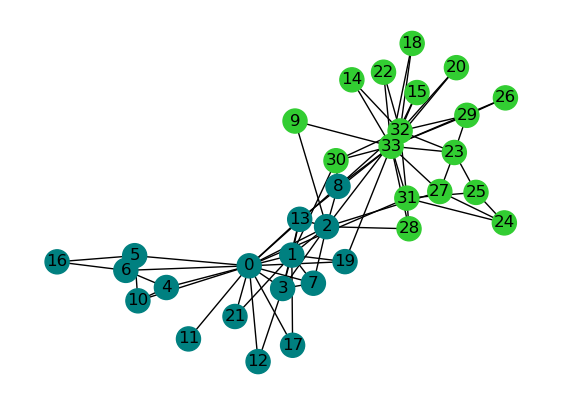

In [5]:
# we actually have some notion of "ground truth" in the karate club...
K = nx.karate_club_graph()
pos = nx.spring_layout(K)

club_color = {
    'Mr. Hi': 'teal',
    'Officer': 'limegreen',
}
node_colors = [club_color[K.nodes[n]['club']] for n in K.nodes]

fig, ax = plt.subplots(1,1,figsize=(7,5),dpi=100)
nx.draw(K, pos, node_color=node_colors, with_labels=True,ax=ax)

plt.show()

## Coding Modularity
Recall from above, the definition of the *modularity* of a partition, $C$ of a graph $A$:

$$Q (A,C) = \frac{1}{2M} \sum_{i,j} \left( A_{ij} - \frac{k_i k_j}{2M} \right) \delta (C_i,C_j) $$

What are the key steps we'll need to do in order to implement this?

In [ ]:
dictionary_partition = {i:0 for i in K.nodes()}
list_partition = [0] * K.number_of_nodes()
list_of_lists_partition = [[i for i in K.nodes()]]

In [3]:
# Your turn! 

In [11]:
G = nx.karate_club_graph()

In [16]:
dict_partition = {i:0 for i in G.nodes()}
A = nx.to_numpy_array(G, weight = None)
M = G.number_of_edges()
Q = 0.0

for i in G.nodes():
    for j in G.nodes():
        if dict_partition[i] == dict_partition[j]:
            A_ij = A[i,j]
            ki = sum(A[i])
            kj = sum(A[j])
            Q += (A_ij - (ki*kj/(2*M)))
Q /= 2*M

In [17]:
Q

-3.843079700625542e-17

_________________

In [24]:
def calculate_modularity(G, partition):
    """
    Calculates the modularity score for a given partition of the graph, whether the graph is weighted or unweighted.
    
    Modularity is a measure of the strength of division of a network into communities. It compares the actual 
    density of edges within communities to the expected density if edges were distributed randomly. For weighted 
    graphs, the weight of the edges is taken into account.

    The modularity Q is calculated as:
    
    Q = (1 / 2m) * sum((A_ij - (k_i * k_j) / (2m)) * delta(c_i, c_j))

    where:
    - A_ij is the weight of the edge between nodes i and j (1 if unweighted).
    - k_i is the degree of node i (or the weighted degree for weighted graphs).
    - m is the total number of edges in the graph, or the total weight of the edges if the graph is weighted.
    - delta(c_i, c_j) is 1 if nodes i and j belong to the same community, and 0 otherwise.

    Parameters:
    -----------
    G : networkx.Graph
        The input graph, which can be undirected and either weighted or unweighted. The graph's nodes represent the 
        entities, and its edges represent connections between them.
    
    partition : list of sets
        A list of sets where each set represents a community. Each set contains the nodes belonging to that community. 
        For example, [{0, 1, 2}, {3, 4}] represents two communities, one with nodes 0, 1, and 2, and another with nodes 
        3 and 4.
    
    Returns:
    --------
    float
        The modularity score for the given partition of the graph. A higher score indicates stronger community structure, 
        and a lower (or negative) score suggests weak or no community structure.

    Notes:
    ------
    - If the graph has weights, they will be used in the modularity calculation. If no weights are present, the function 
      assumes each edge has a weight of 1 (i.e., unweighted).
    
    - The function assumes that all nodes in the graph are assigned to exactly one community. If any node is missing 
      from the community list, it is treated as not belonging to any community, and the results may not be accurate.
    
    - If the graph has no edges, the modularity is undefined, and this function will return 0 because the total number 
      of edges (2m) would be zero.
    
    Example:
    --------
    >>> import networkx as nx
    >>> G = nx.karate_club_graph()
    >>> communities = [{0, 1, 2, 3, 4}, {5, 6, 7, 8, 9, 10}]
    >>> modularity_score = calculate_modularity(G, communities)
    >>> print("Modularity:", modularity_score)
    
    References:
    -----------
    Newman, M. E. J., & Girvan, M. (2004). Finding and evaluating community structure 
    in networks. Physical Review E, 69(2), 026113.
    """
  
    def remap_partition(partition):
        """
        Converts and remaps a partition to a list-of-lists structure suitable for modularity calculations.

        This function remaps the input partition (whether it's in dictionary form or a flat list of community labels) 
        to a list-of-lists format, where each list represents a community and contains the nodes in that community. 
        The function also ensures that community labels are contiguous integers starting from 0, which is typically 
        required for modularity-based algorithms.
        """

        # if partition is a dictionary where the keys are nodes and values communities
        if type(partition)==dict:
            unique_comms = np.unique(list(partition.values()))
            comm_mapping = {i:ix for ix,i in enumerate(unique_comms)}
            for i,j in partition.items():
                partition[i] = comm_mapping[j]

            unique_comms = np.unique(list(partition.values()))
            communities = [[] for i in unique_comms]
            for i,j in partition.items():
                communities[j].append(i)
                
            return communities

        # if partition is a list of community assignments
        elif type(partition)==list and\
                not any(isinstance(el, list) for el in partition):
            unique_comms = np.unique(partition)
            comm_mapping = {i:ix for ix,i in enumerate(unique_comms)}
            for i,j in enumerate(partition):
                partition[i] = comm_mapping[j]

            unique_comms = np.unique(partition)
            communities = [[] for i in np.unique(partition)]
            for i,j in enumerate(partition):
                communities[j].append(i)

            return communities

        # otherwise assume input is a properly-formatted list of lists
        else:
            communities = partition.copy()
            return communities


    # We now should have a list-of-lists structure for communities
    communities = remap_partition(partition)
    
    # Total weight of edges in the graph (or number of edges if unweighted)
    if nx.is_weighted(G):
        m = G.size(weight='weight')
        degree = dict(G.degree(weight='weight'))  # Weighted degree for each node
    else:
        m = G.number_of_edges()  # Number of edges in the graph
        degree = dict(G.degree())  # Degree for each node (unweighted)

    # Modularity score
    modularity_score = 0.0
    
    # Loop over all pairs of nodes i, j within the same community
    for community in communities:
        for i in community:
            for j in community:
                # Get the weight of the edge between i and j, or assume weight 1 if unweighted
                if G.has_edge(i, j):
                    A_ij = G[i][j].get('weight', 1)  # Use weight if available, otherwise assume 1
                else:
                    A_ij = 0  # No edge between i and j

                # Expected number of edges (or weighted edges) between i and j in a random graph
                expected_edges = (degree[i] * degree[j]) / (2 * m)

                # Contribution to modularity
                modularity_score += (A_ij - expected_edges)

    # Normalize by the total number of edges (or total edge weight) 2m
    modularity_score /= (2 * m)


    return modularity_score

____________

## Method: Girvan Newman

The Girvan-Newman method [1] is a *divisive* algorithm that iteratively removes the edges connecting the different clusters until the optimal partition is found and the communities are fully isolated. The algorithm calculates a score for each edge (in this case, *edge betweenness*, though others could have been considered), ranks these scores, and iteratively removes them from the graph. At each iteration, the modularity of the partition of (dis)connected components is measured. We repeat this step until the graph has no edges, and the partition with the highest modularity is chosen.

![](images/girvan_newman.png)

[1] Girvan M. & Newman M.E.J. (2002). **Community structure in social and biological networks**. Proceedings of the National Academy of Sciences, 99, 7821–7826. https://doi.org/10.1073/pnas.122653799.

In [25]:
# 1. Calculate score for each edge 
# 2. Remove edge with highest score
# 3. Create partition based on connected components
# 4. Calculate modularity of partition
# 5. Repeat
G = nx.karate_club_graph()
H = G.copy()
modularity_list = []
partition_list = []

while H.number_of_edges() > 1:
    edge_betweenness = nx.edge_betweenness_centrality(H)
    special_edge = max(edge_betweenness, key = edge_betweenness.get)
    H.remove_edge(*special_edge)
    partition_x = list(nx.connected_components(H))
    Q_x = calculate_modularity(H, [list(i) for i in list(partition_x)])
    modularity_list.append(Q_x)
    partition_list.append(partition_x)

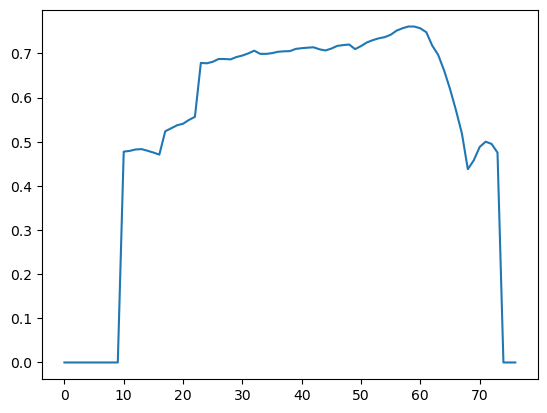

In [26]:
plt.plot(modularity_list)

In [28]:
import networkx as nx
from networkx.algorithms.community import modularity
# import community

def girvan_newman(H, output='dict'):
    """
    Implements the Girvan-Newman algorithm for detecting communities in a graph.
    
    The Girvan-Newman method works by iteratively removing edges from the graph 
    based on their edge betweenness centrality, which is a measure of the frequency 
    with which edges appear on the shortest paths between pairs of nodes. As edges 
    with high centrality values are removed, the graph breaks down into smaller 
    connected components, each representing a community.
    
    Parameters:
    -----------
    H : networkx.Graph
        The input graph on which to perform community detection.
    
    output : strong, optional (default='dict')
        'dict'  - the algorithm will return a dictionary where the keys correspond to
                  nodes and values are the community label
        'lists' - a list of lists of length n_comms will be returned, such that the ith
                  element of the list contains a nodelist of nodes that are assigned to
                  community i
        'list'  - a list of community assignments, in the same order as G.nodes()
    
    Returns:
    --------
    dict:
        A dictionary or similar object where the keys are node identifiers and
        the values are  community labels (integers), indicating which
        community each node belongs to.
    
    
    Notes:
    ------
    - Modularity is a measure of the strength of the division of a network into 
      communities. Higher values indicate stronger community structure.
    
    - The Girvan-Newman algorithm is computationally expensive (O(n*m^2), where n 
      is the number of nodes and m is the number of edges), making it impractical 
      for very large graphs.
    
    Example:
    --------
    >>> import networkx as nx
    >>> G = nx.karate_club_graph()
    >>> partition = girvan_newman(G)
    >>> for node, community in partition.items():
    >>>     print(f"Node {node} belongs to community {community}")
    """

    # Make a copy of the graph so we don't modify the original graph
    G = H.copy()

    # Initialize variables to track the best partition and modularity
    best_partition = None
    best_modularity = -1

    # Keep removing edges until all components are disconnected
    while G.number_of_edges() > 0:
        # Compute edge betweenness centrality for all edges
        edge_betweenness = nx.edge_betweenness_centrality(G)

        # Find the edge with the highest betweenness
        max_edge = max(edge_betweenness, key=edge_betweenness.get)

        # Remove the edge with the highest betweenness
        G.remove_edge(*max_edge)

        # Find connected components (each component is a community)
        components = list(nx.connected_components(G))

        # Assign community labels to nodes
        community_dict = {}
        for i, component in enumerate(components):
            for node in component:
                community_dict[node] = i

        # Compute modularity for the current partition on the original graph
        try:
            current_modularity = modularity(H, components)
        except ZeroDivisionError:
            # If division by zero occurs, set modularity to 0
            current_modularity = 0

        # If this modularity is better than the best so far, store it
        if current_modularity > best_modularity:
            best_modularity = current_modularity
            best_partition = community_dict.copy()

    best_partition = {i:best_partition[i] for i in G.nodes()}
    # Return the best partition
    if output == 'dict':
        return best_partition

    if output == 'list':
        return list(best_partition.values())
        
    if output == 'lists':
        comm_out = [[] for i in np.unique(list(best_partition.values()))]
        for i,j in best_partition.items():
            comm_out[j].append(i)
        return comm_out

Best Modularity: 0.3849721706864564


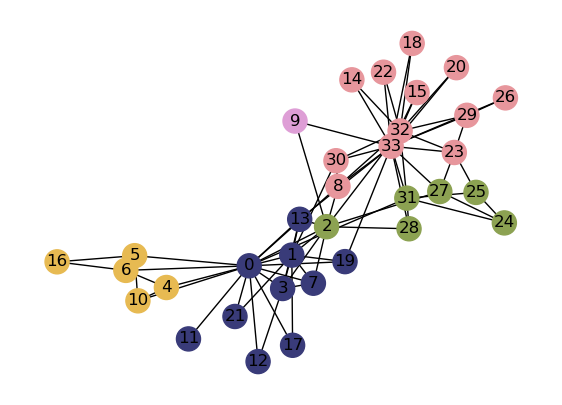

In [29]:
# Create a graph
G = nx.karate_club_graph()

# Run the Girvan-Newman algorithm with modularity tracking
best_partition = girvan_newman(G)

# Output the best modularity score
print("Best Modularity:", calculate_modularity(G, best_partition))

unique_comms = np.unique(list(best_partition.values()))
comm_colors = plt.cm.tab20b(np.linspace(0,1,len(unique_comms)))
comm_color_dict = dict(zip(unique_comms, comm_colors))

node_colors = [comm_color_dict[best_partition[i]] for i in K.nodes]

fig, ax = plt.subplots(1,1,figsize=(7,5),dpi=100)

nx.draw(G, pos=pos, node_color=node_colors, with_labels=True, ax=ax)

plt.show()

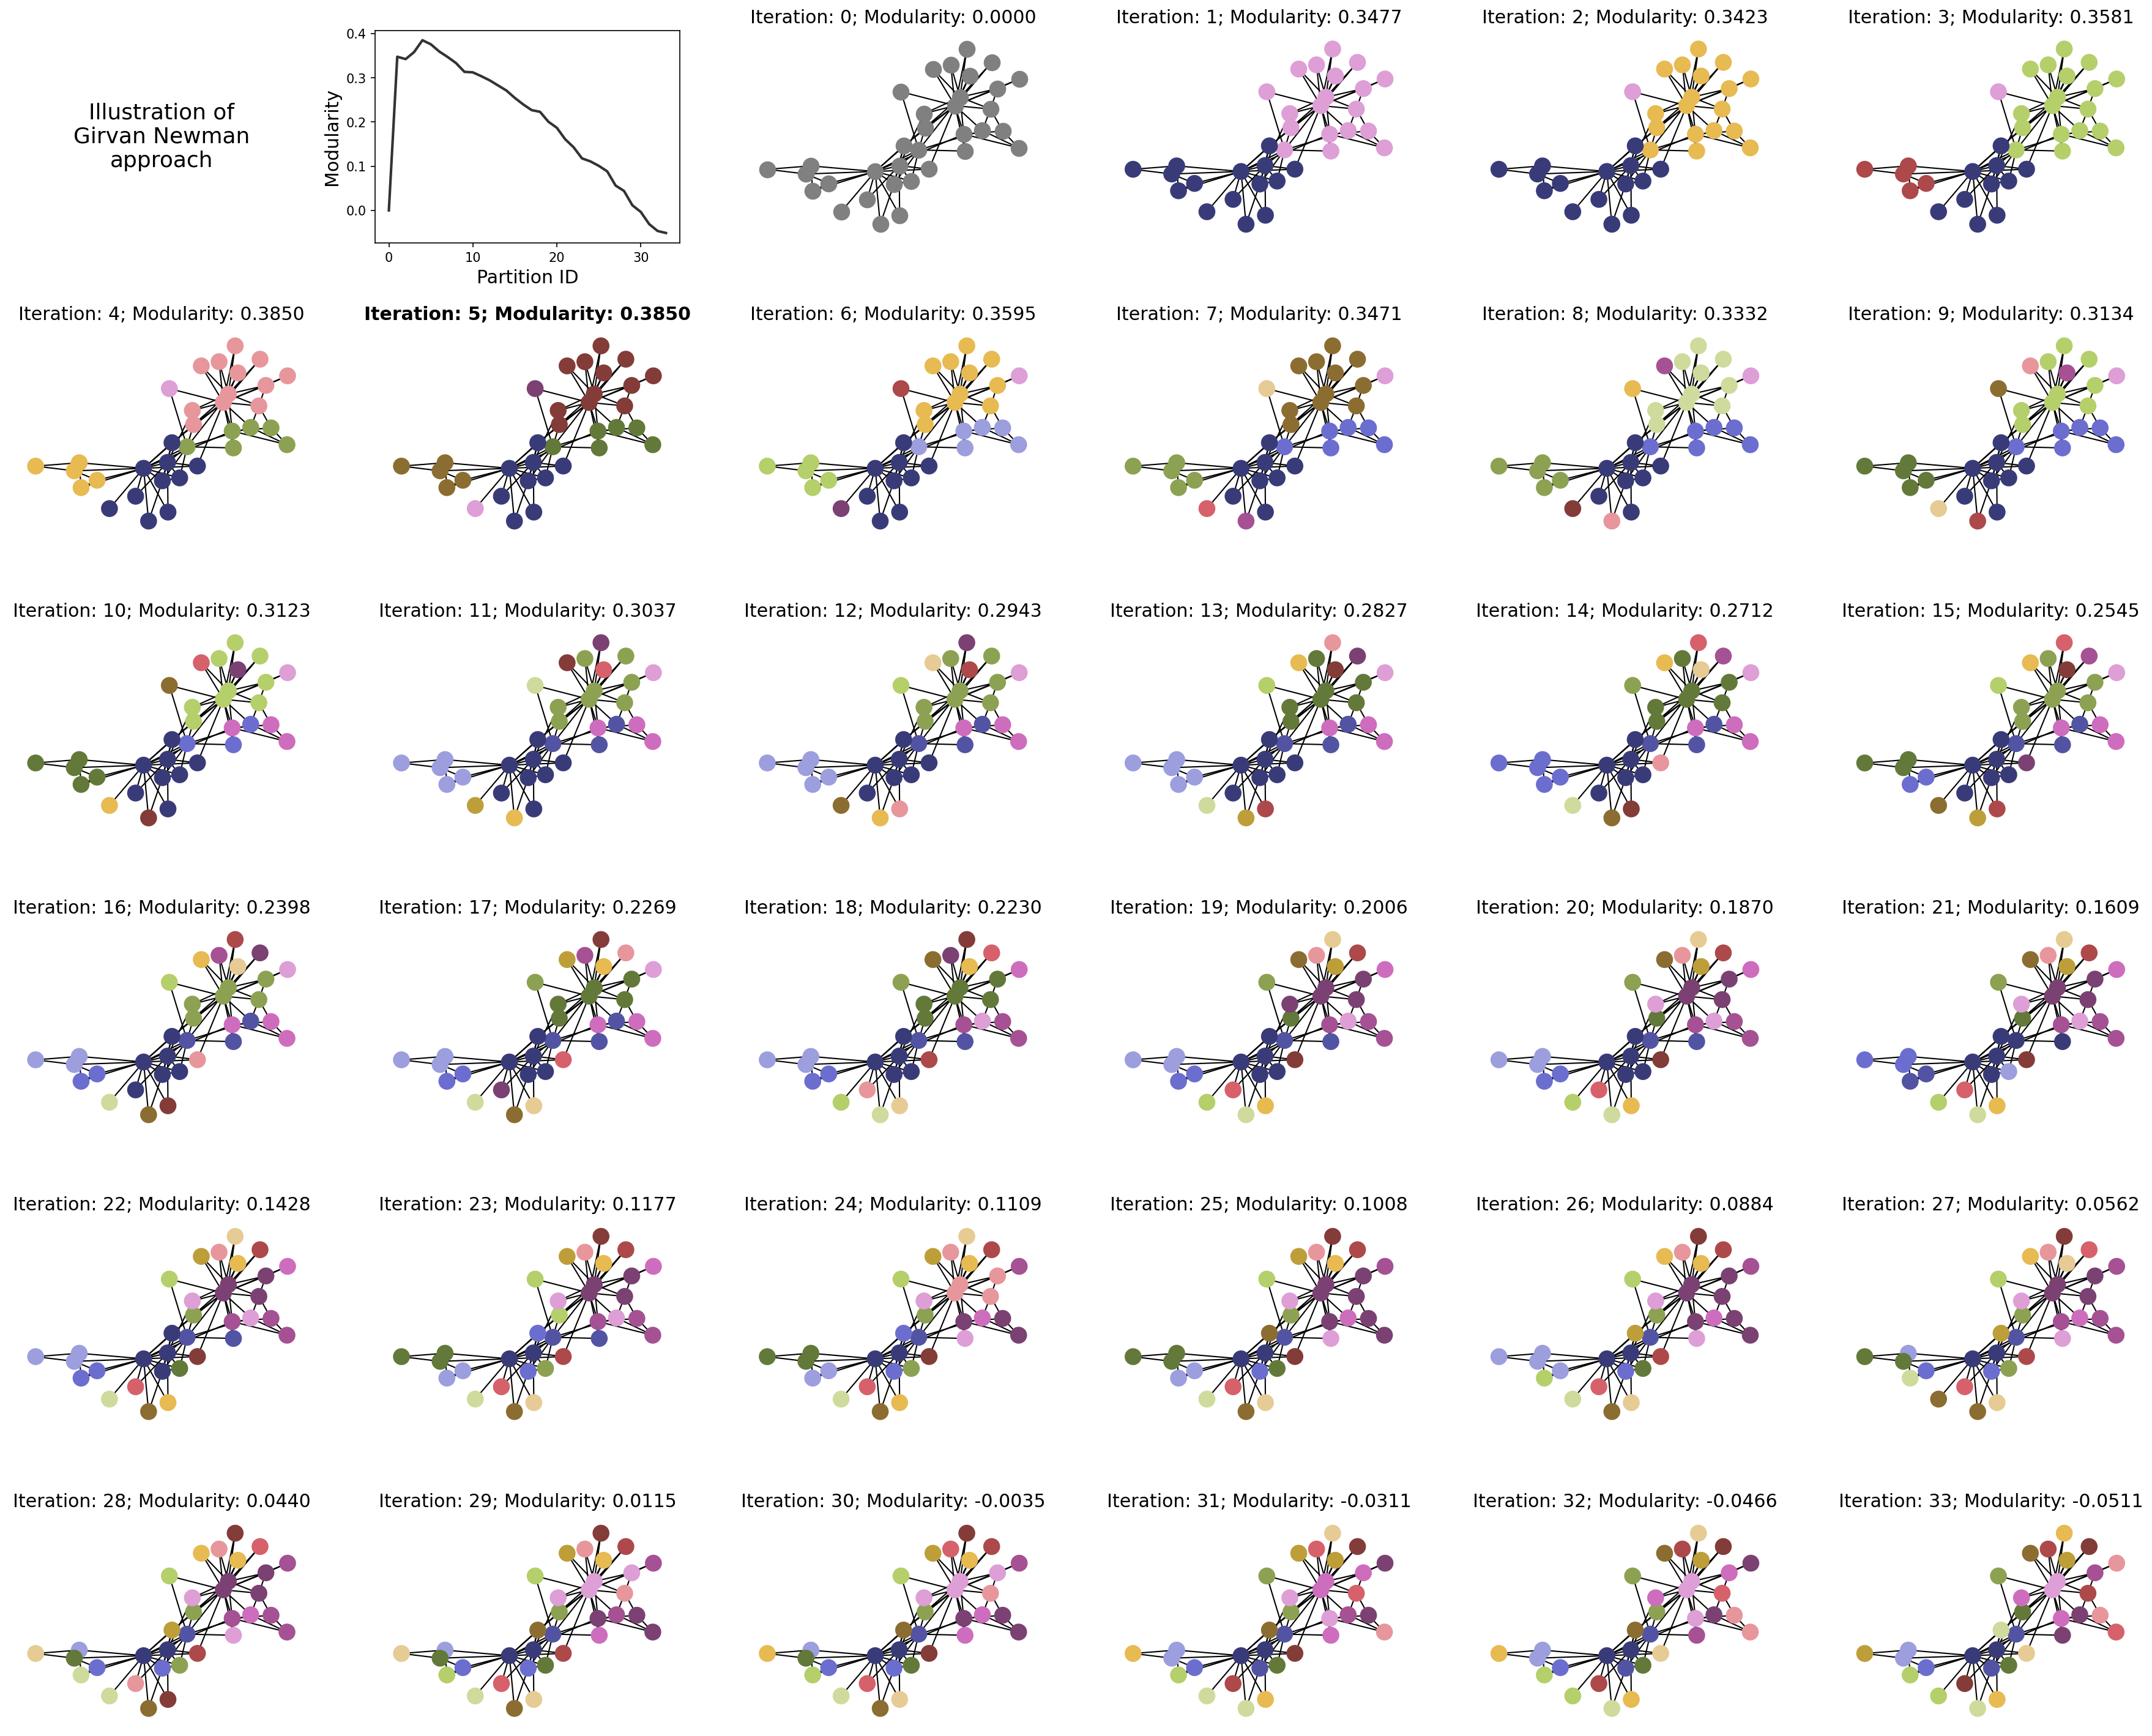

In [30]:
import itertools as it
w = 5.0
h = 4.0
nrows = 6
ncols = 6
tups = list(it.product(range(nrows), range(ncols)))

fig, ax = plt.subplots(nrows, ncols, figsize=(w*ncols,h*nrows), dpi=150)
plt.subplots_adjust(wspace=0.2, hspace=0.4)


gn = list(nx.community.girvan_newman(G))
best_partition = {i:i for i in G.nodes()}
best_modularity = 0
mods = [0.0]

for ii,gn_i in enumerate(gn):
    part_i = {i:0 for i in G.nodes()}
    node_comms_i = list(gn_i)
    ncomms_i = list(range(len(node_comms_i)))
    for ix, p_i in enumerate(gn_i):
        for v_i in p_i:
            part_i[v_i] = ncomms_i[ix]

    mod_i = calculate_modularity(G, part_i)
    mods.append(mod_i)
    if mod_i > best_modularity:
        best_partition = part_i.copy()
        best_modularity = mod_i

    unique_comms = np.unique(list(part_i.values()))
    comm_colors = plt.cm.tab20b(np.linspace(0,1,len(unique_comms)))
    comm_color_dict = dict(zip(unique_comms, comm_colors))

    node_colors = [comm_color_dict[part_i[i]] for i in G.nodes]
    nx.draw(G, pos, node_color=node_colors, node_size=150,
            ax=ax[tups[ii+3]])
    
    ax[tups[ii+3]].set_title('Iteration: %i; Modularity: %.4f'%(ii+1,mod_i),
                             fontsize='x-large')



ax[tups[np.argmax(mods)+3]].set_title('Iteration: %i; Modularity: %.4f'%(np.argmax(mods)+1,best_modularity),
                         fontsize='x-large', fontweight='bold')
    

ax[tups[0]].text(0.5,0.5,'Illustration of\nGirvan Newman\napproach',
                 ha='center',va='center',fontsize='xx-large')
ax[tups[0]].set_xlim(0,1)
ax[tups[0]].set_ylim(0,1)
ax[tups[0]].set_axis_off()

ax[tups[1]].plot(mods, lw=2, color='.2')
ax[tups[1]].set_xlabel('Partition ID', fontsize='x-large')
ax[tups[1]].set_ylabel('Modularity', fontsize='x-large')

ax[tups[2]].set_title('Iteration: %i; Modularity: %.4f'%(0,0.0),
                             fontsize='x-large')
nx.draw(G, pos, node_color='.5', node_size=150,
        ax=ax[tups[2]])
ax[tups[2]].set_axis_off()

    

plt.show()

______________
### Challenges in Community Detection

Despite the wide use of community detection, several challenges persist:

- **Resolution Limit**: Modularity-based methods can fail to detect small communities due to the resolution limit, where small but dense communities might be merged into larger ones.
- **Overlapping Communities**: Many real-world networks contain overlapping communities (e.g., a person belonging to multiple social groups), but traditional algorithms are typically designed to find disjoint partitions.
- **Computational Complexity**: For very large networks, many algorithms become computationally prohibitive. Efficient approximations or parallel implementations are often required.
- **Ground Truth Validation**: In many networks, the "ground truth" community structure is unknown, making it difficult to validate or compare different community detection methods.

_________
#### Modularity Landscape

![](images/good_montjoye_clauset.png)

Figure: Low-dimensional visualization of the modularity landscape for the metabolic network of the *spirochete Treponema pallidum*. Partitions with high modularity have high *degeneracy*, which can be seen due to the large number of local maxima all with approximately the same modularity (see the red inset above the landscape). These modularity values in the "table top" of the landscape all are approximately equivalent to the maximum modularity, despite the fact that they correspond to different partitions. *Figure from Good, de Montjoye & Clauset (2009)*.

Many heuristics give good estimates for the modularity maximization problem, however this can be due to the fact that there is an high degeneracy of large modularity partitions. This problem is particularly severe on graphs with hierarchical community structure (i.e. in many real world networks).

_________

Another problem is that having "high" modularity does not imply that the partitioning is good: i.e. random graphs might have high modularity even when there is no community structure in them. Indeed, in the standard modularity formulation we are only considering the average (i.e. expected) value of connections between nodes, but we are not considering possible fluctuations. One possible solution is to look at the ___z-score___ of the modularity value after having generated multiple realizations of the null model:

$$ Q_z = \frac{Q_{max} - \langle Q \rangle_{null}}{\sigma(Q)_{null}} $$

___________

## Method: Louvain Algorithm

In the years that followed the Girvan-Newman approach, we saw dozens of new community detection algorithms emerge. One that persisted for several years as a popular approach is called the ***Louvain Algorithn*** [1]. It is implemented as follows:

1. **Initialization:** Each node starts as its own community.

2. **Phase 1 - Modularity Optimization:**
- For each node $i$, the algorithm evaluates the gain in modularity from moving that node to each of its neighbors' $j$ communities.
- The node is placed in the community that maximizes the modularity gain. If no such move increases modularity, the node stays in its current community.

3. **Phase 2 - Community Aggregation:**
- Once no further modularity gains can be made, each community is collapsed into a single node, creating a new, smaller network.
- The process repeats until modularity can no longer be improved.

4. **Output:** The algorithm outputs the community structure that maximizes the modularity.

![](images/louvain.png)

[1] Blondel, V. D., Guillaume, J. L., Lambiotte, R., & Lefebvre, E. (2008). Fast unfolding of communities in large networks. Journal of Statistical Mechanics, 2008(10), P10008. https://doi.org/10.1088/1742-5468/2008/10/P10008

***Why it is efficient?***

$$ \Delta Q =  \left[ \frac{S_{C}^{in} + s_{i}^{in}}{2W} - \left( \frac{S_{C}^{tot} + s_{i}}{2W} \right)^2  \right]   -   \left[ \frac{S_{C}^{in}}{2W} - \left( \frac{S_{C}^{tot}}{2W} \right)^2 - \left( \frac{s_i}{2W} \right)^2  \right]  $$

where $s_i$ is the strength of node $i$, $s_{i,c}$ is the _internal_ strength of node $i$,$S_{C}^{in} = \sum_{i \in C} s_{i}^{in}$ is the _internal_ strength of cluster $C$, $S_{C}^{tot} = \sum_{i \in C} s_i$ is the total strength of cluster $C$, and $W$ is the sum of the weights of all the links in the network.

In practice, the complexity of this algorithm is approximagely $O(N \log N)$.

Below is an example of the (much more complicated!) functions involved in the Louvain method.

In [8]:
import networkx as nx
from collections import defaultdict
from random import shuffle


def get_modularity(G, partition):
    """
    Calculate the modularity of the current partition of the graph G.
    
    Parameters:
    G (networkx.Graph): The graph for which modularity is to be calculated.
    partition (dict): A dictionary where keys are nodes and values are community labels.

    Returns:
    float: The modularity score for the given partition.
    """
    E_c = defaultdict(float)
    k_c = defaultdict(float)
    
    M = 0.0
    for source_node, target_node, w in G.edges(data = True):
        M += w['weight'] 
        if partition[source_node] ==  partition[target_node]:
            E_c[partition[source_node]] += w['weight']
    
    degrees = G.degree(weight='weight') 
    for node in G.nodes():
        k_c[partition[node]] += degrees[node]
        
    Q = sum( [ (E_c[c]/M) - (k_c[c]/(2.0*M))**2   for c in k_c.keys()     ]   )
    return Q


def local_optimization_step(H, Q_max, verbose=False):
    """
    Perform a local optimization step on the graph to maximize modularity by 
    moving nodes to neighboring communities.

    Parameters:
    H (networkx.Graph): The graph with community assignments as node attributes.
    Q_max (float): The current maximum modularity.
    verbose (bool): If True, print the current iteration number.

    Returns:
    float: The updated maximum modularity after the optimization step.
    """
    nodes = list(H.nodes())
    shuffle(nodes)

    something_changed = True
    iteration = 0

    while something_changed:
        iteration += 1
        if verbose:
            print(f'Iteration: {iteration}')
        
        something_changed = False  # Reset flag for changes made this iteration
        
        for node_i in nodes:
            current_partition = nx.get_node_attributes(H, 'community')
            current_community = current_partition[node_i]
            best_community = current_community
            best_diffQ = 0
            
            # Calculate the modularity change for moving node to each neighbor's community
            for neighbor in H.neighbors(node_i):
                neighbor_community = H.nodes[neighbor]['community']
                if neighbor_community != current_community:  # Only move if different
                    current_partition[node_i] = neighbor_community  # Temporarily move
                    Q_current = get_modularity(H, current_partition)
                    diffQ = Q_current - Q_max

                    if diffQ > best_diffQ:
                        best_diffQ = diffQ
                        best_community = neighbor_community

            # Apply the best community change if it improves modularity
            if best_community != current_community:
                H.nodes[node_i]['community'] = best_community
                Q_max += best_diffQ
                something_changed = True
        
        shuffle(nodes)  # Shuffle nodes for the next iteration

    return Q_max


def network_aggregation_step(H):
    """
    Perform the network aggregation step by collapsing communities into super-nodes 
    and recalculating edge weights between communities.

    Parameters:
    H (networkx.Graph): The graph where each node has a 'community' attribute.

    Returns:
    networkx.Graph: A new graph where nodes represent communities from the previous step.
    """
    edges = defaultdict(float)  # Dictionary to store new edges between communities

    # Aggregate edges between communities
    for source_node, target_node, w in H.edges(data=True):
        c1 = H.nodes[source_node]['community']
        c2 = H.nodes[target_node]['community']

        # Sort communities to ensure consistent ordering
        edge = tuple(sorted((c1, c2)))

        # Sum the edge weights between communities
        edges[edge] += w['weight']

    # Create a new aggregated graph where nodes are communities
    H_new = nx.Graph()
    H_new.add_edges_from(edges.keys())
    nx.set_edge_attributes(H_new, values=edges, name='weight')

    # Set the community attribute of each node to itself (each node is its own community initially)
    for node in H_new.nodes():
        H_new.nodes[node]['community'] = node
    
    return H_new


def reindex_communities(partition):
    """
    Reindex the communities in the partition so that community labels are continuous.

    Parameters:
    partition (dict): A dictionary where keys are nodes and values are community labels.

    Returns:
    dict: A new partition where community labels are reindexed to start from 0.
    """
    # Create a mapping from old community labels to new indices
    new_index = {community: c for c, community in enumerate(set(partition.values()))}
    
    # Reindex the partition using the new indices
    partition = {node: new_index[community] for node, community in partition.items()}
    
    return partition


def louvain_method(G, init=None):
    """
    Run the Louvain method for community detection on a graph.

    Parameters:
    G (networkx.Graph): The input graph where nodes and edges define the structure.
    init (dict): Optional initial partition. If None, each node is its own community.

    Returns:
    dict: The final partition of the graph with node assignments to communities.
    """
    # Make a copy of the graph to modify
    H = G.copy()

    # Initialize partition where each node is its own community, or use the provided initial partition
    if init:
        best_partition = init.copy()
    else:
        best_partition = {node: c for c, node in enumerate(H.nodes())}
    nx.set_node_attributes(H, values=best_partition, name='community')

    # Map each community to its original set of nodes
    aggregate_to_original = {node: [node] for node in H.nodes()}

    # Initialize edge weights if not present
    weights = {(node_i, node_j): 1.0 for node_i, node_j in H.edges()}
    nx.set_edge_attributes(H, values=weights, name='weight')

    # Compute initial modularity
    Q_max = calculate_modularity(H, best_partition)

    N = len(H)  # Number of nodes (communities)
    N_prev = -1  # Previous number of communities

    # Main loop: optimize modularity and aggregate communities until no change
    while N != N_prev:
        # 1) Perform local modularity optimization
        Q_max = local_optimization_step(H, Q_max)

        # Get the new community assignments after optimization
        best_partition_aggregate = nx.get_node_attributes(H, 'community')

        # Update the mapping from original nodes to new communities
        aggregate_to_original_old = aggregate_to_original.copy()
        aggregate_to_original = defaultdict(list)
        for old_community, new_community in best_partition_aggregate.items():
            for node in aggregate_to_original_old[old_community]:
                aggregate_to_original[new_community].append(node)
                best_partition[node] = new_community

        # 2) Perform network aggregation to create a new graph
        H = network_aggregation_step(H)

        # Update the number of nodes (communities)
        N_prev = N
        N = H.number_of_nodes()

    # Reindex the final community labels for clarity
    best_partition = reindex_communities(best_partition)

    return best_partition

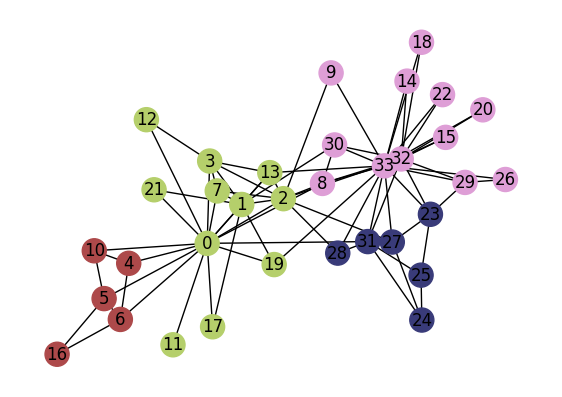

In [9]:
G = nx.karate_club_graph()
partition = louvain_method(G)

colors_sns = plt.cm.tab20b(np.linspace(0,1,len(np.unique(list(partition.values())))))
colors_nodes = [colors_sns[partition[node]] for node in G.nodes()]

fig, ax = plt.subplots(1,1,figsize=(7,5),dpi=100)

nx.draw(G, pos=pos, node_color=colors_nodes, with_labels=True, ax=ax)

plt.show()

__________

### Community detection package(s)

The Louvain algorithm is also implemented in this `community` Python package.

https://python-louvain.readthedocs.io/en/stable/index.html

`import community`

In [3]:
import community

ModuleNotFoundError: No module named 'community'

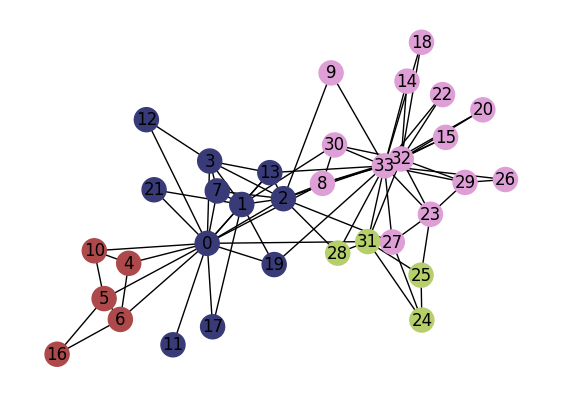

In [11]:
G = nx.karate_club_graph()
partition = community.best_partition(G)

colors_sns = plt.cm.tab20b(np.linspace(0,1,len(np.unique(list(partition.values())))))
colors_nodes = [colors_sns[partition[node]] for node in G.nodes()]

fig, ax = plt.subplots(1,1,figsize=(7,5),dpi=100)

nx.draw(G, pos=pos, node_color=colors_nodes, with_labels=True, ax=ax)

plt.show()

____________

## Other common algorithms

### 1. Spectral Optimization

Based on a modularity matrix:

$$ B_{i,j} = A_{i,j} - \frac{k_ik_j}{2M} $$

Then,

\begin{eqnarray}
Q &=& \frac{1}{2M} \sum_{i,j} \left( A_{i,j} - \frac{k_ik_j}{2M} \right) \delta(C_i,C_j) \\
 &=& \frac{1}{4M} \sum_{i,j} \left( A_{i,j} - \frac{k_ik_j}{2M} \right) (s_is_j + 1)  \\
 &=& \frac{1}{4M} \sum_{i,j} B_{i,j}s_is_j   \\ 
 &=& \frac{1}{4M} s^TBs 
\end{eqnarray}

Notice that:
1. $ \frac{s_is_j + 1}{2} $ is equal to 1 if $i$ and $j$ belong to the same community, 0 otherwise.
2. $ \sum_{i,j}A_{i,j} = \sum_{i}k_{i} = 2M $. 

Matrix $B$ is ___symmetric___ and it has $N$ orthonormal eigenvectors. Then, it can be shown that the previous equation can be rewritten as:

$$ Q = \frac{1}{4M} \sum_{i} \left( u_i^Ts \right)^2\lambda_i ,$$

where $u_i$ is an eigenvector of $B$ associated to the eigenvalue $\lambda_i$.

Therefore, the modularity maximization consists in setting the values of $s$ as to maximize the contribution of the leading eigenvalue (i.e. $\lambda_1$) of $B$.

Under the constraint that the entries of $s$ have to be either $+1$ or $-1$, we can find the optimal graph partitioning by setting $s_i = 1$ if $u_i > 0$; $s_i = -1$, otherwise.

### 2. Infomap

This is an ***information theoretic approach*** that reveals community structure in weighted and directed networks. The main idea is to find the best compressed description of the path of a random walker traversing the graph. 

In practice, we want to minimize the ***map equation***:

$$ L(M) = q_{between}H(\mathbb{L}) + \sum_{i=1}^m p_{within}^iH(\mathbb{P}^i) ,$$

where $q_{between}$ is the probability that the random walker moves in a different module at each step, $p_{within}^i$ is the probability that the random walker next step will be within the same module $i$, $H(x)$ denotes the *entropy* of the codewords used to describe $x$ using *Huffman coding* (https://en.wikipedia.org/wiki/Huffman_coding).

![](images/infomap.png)

[1] Rosvall, M., & Bergstrom, C.T. (2008). Maps of random walks on complex networks reveal community structure. Proceedings of the National Academy of Sciences, 105(4), 1118-1123. https://doi.org/10.1073/pnas.0706851105

### 3. Your turn! 
In the remaining time, it's your chance to do a short mini-lit review. Find a community detection algorithm by searching google scholar. See if you can quickly skim through any descriptions you find on it to answer the following:
- What measure is being optimized (i.e., how do we know a given partition is optimal---or even good---under this approach?)
- Algorithmically, how are partitions selected/sampled?
- When did this technique come out? How many citations does it have?

_________

## Punchline: These methods all have a common failing
... and it's the topic of our next lesson!

__________
## Next time...
Clustering & Community Detection 2 — Contemporary! `class_11_communities2.ipynb`
_______

## References and further resources:

1. Class Webpages
    - Jupyter Book: https://asmithh.github.io/network-science-data-book/intro.html
    - Github: https://github.com/asmithh/network-science-data-book
    - Syllabus and course details: https://brennanklein.com/phys7332-fall24
2. Fortunato, S. (2010). Community detection in graphs. *Physics Reports*, 486(3), 75-174. https://doi.org/10.1016/j.physrep.2009.11.002
3. Fortunato, S., & Hric, D. (2016). Community detection in networks: A user guide. *Physics Reports*, 659, 1-44. https://doi.org/10.1016/j.physrep.2016.09.002
4. Chakraborty, T., Dalmia, A., Mukherjee, A., & Ganguly, N. (2017). Metrics for community analysis: A survey. *ACM Computing Surveys (CSUR)*, 50(4), 1-37. https://dl.acm.org/doi/10.1145/3091106
5. Good, B. H., De Montjoye, Y. A., & Clauset, A. (2010). Performance of modularity maximization in practical contexts. *Physical Review E*, 81(4), 046106. https://link.aps.org/doi/10.1103/PhysRevE.81.046106
6. Girvan M. & Newman M.E.J. (2002). Community structure in social and biological networks. Proceedings of the National Academy of Sciences, 99, 7821–7826. https://doi.org/10.1073/pnas.122653799
7. Newman, M.E.J., & Girvan, M. (2004). "Finding and evaluating community structure in networks." *Physical Review E*, 69(2), 026113. https://doi.org/10.1103/PhysRevE.69.026113
8. Rosvall, M. & Bergstrom, C.T. (2008). Maps of random walks on complex networks reveal community structure. *Proceedings of the National Academy of Sciences*, 105(4), 1118-1123. https://doi.org/10.1073/pnas.0706851105
9. Blondel, V. D., Guillaume, J. L., Lambiotte, R., & Lefebvre, E. (2008). Fast unfolding of communities in large networks. Journal of Statistical Mechanics, 2008(10), P10008. https://doi.org/10.1088/1742-5468/2008/10/P10008